In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
from sklearn.metrics import roc_curve, auc
import random
import scipy
from statsmodels.stats.multitest import multipletests
gpp.set_aesthetics(context = 'paper')

### QC and Z-score calculation

In [2]:
#read in read counts
reads_df = pd.read_table('../../Data/CRISPRkoData/counts-STS_A375_A549_CP0081.txt')
reads_df = reads_df.drop(['Construct IDs','Unlabeled Sample Barcodes'],axis=1)
reads_df

,Construct Barcode,A375_CP0081_rep A,A375_CP0081_rep B,A549_CP0081_rep A,A549_CP0081_rep B,CP0081 pDNA
0,AAAAAAGAAAGGATACGTCC,920,1448,1319,1254,437
1,AAAAACAGCTGATGAAACCT,681,804,1049,1383,390
2,AAAAACCTGGGAAAGATATA,1270,2073,2501,2248,480
3,AAAAAGAGGCGGCATTACAG,1224,1382,2850,2305,688
4,AAAAAGATAGATGTGCTAAA,92,296,236,258,521
...,...,...,...,...,...,...
60545,TTTGTGGAGCCGGTACATGA,2405,4048,2532,2478,619
60546,TTTGTGGGTACATCTAACCC,1647,901,2052,1142,427
60547,TTTGTGGTAGGAGTAGGTGT,260,110,671,757,531
60548,TTTGTGTATTACCTCAGGAA,921,4601,1357,1606,488


In [5]:
#read in annotations
annotations_df = pd.read_table('../../Data/CRISPRkoData/CP0081_GRCh38_Ensembl_CRISPRko_strict_gene_20250425.chip')
annotations_df

,Barcode Sequence,Gene Symbol,Gene ID
0,AAAAAAGAAAGGATACGTCC,FHIT,ENSG00000189283
1,AAAAACAGCTGATGAAACCT,CD58,ENSG00000116815
2,AAAAACAGCTGATGAAACCT,ENSG00000298543,ENSG00000298543
3,AAAAACCTGGGAAAGATATA,ZNF669,ENSG00000188295
4,AAAAAGAGGCGGCATTACAG,ENSG00000273957,ENSG00000273957
...,...,...,...
68281,TTTGTGGAGCCGGTACATGA,CHPF2,ENSG00000033100
68282,TTTGTGGGTACATCTAACCC,ONE_INTERGENIC_SITE_1026,ONE_INTERGENIC_SITE_1026
68283,TTTGTGGTAGGAGTAGGTGT,JMJD8,ENSG00000161999
68284,TTTGTGTATTACCTCAGGAA,SPANXN3,ENSG00000189252


In [6]:
def lognorm(reads):
    """
    Standardize read counts by calculating reads per million,
    adding a pseudo-count of one, and taking the log2

    :param reads: numpy or pandas array
    :returns: numpy or pandas array
    """
    reads_per_million = (reads/reads.sum())*(10**6)
    lognormed_reads = np.log2(reads_per_million + 1)
    return lognormed_reads

In [7]:
condition_columns = reads_df.columns[1:]
lognorm_df = reads_df.copy()
for column in condition_columns:
    lognorm_df[column] = lognorm_df[column].astype(float)
lognorm_df[condition_columns] = lognorm_df[condition_columns].apply(lognorm)
lognorm_df

,Construct Barcode,A375_CP0081_rep A,A375_CP0081_rep B,A549_CP0081_rep A,A549_CP0081_rep B,CP0081 pDNA
0,AAAAAAGAAAGGATACGTCC,3.824139,3.860735,3.773873,3.875863,3.826832
1,AAAAACAGCTGATGAAACCT,3.425472,3.089369,3.470337,4.007931,3.674873
2,AAAAACCTGGGAAAGATATA,4.260914,4.348138,4.646206,4.673847,3.953096
3,AAAAAGAGGCGGCATTACAG,4.210515,3.798166,4.827590,4.708574,4.444031
4,AAAAAGATAGATGTGCTAAA,1.211874,1.912777,1.708646,1.931577,4.063996
...,...,...,...,...,...,...
60545,TTTGTGGAGCCGGTACATGA,5.146165,5.278646,4.663273,4.809126,4.298931
60546,TTTGTGGGTACATCTAACCC,4.618598,3.235336,4.373283,3.750494,3.795814
60547,TTTGTGGTAGGAGTAGGTGT,2.238852,1.019814,2.897232,3.210808,4.089800
60548,TTTGTGTATTACCTCAGGAA,3.825596,5.458910,3.811892,4.211096,3.975415


In [8]:
filtered_lognorms = lognorm_df.copy()
pdna_cols = ['CP0081 pDNA']
z_low = -3  # minimum z-score
# Z-score the pDNA columns
z_scored_cols = []
for pdna in pdna_cols:
    z_col = pdna + '_z'
    filtered_lognorms[z_col] = (filtered_lognorms[pdna] - filtered_lognorms[pdna].mean())/filtered_lognorms[pdna].std()
    z_scored_cols.append(z_col)
# Filter by z-score
filtered_lognorms = filtered_lognorms[filtered_lognorms[z_scored_cols].min(axis = 1) > z_low]
# Drop z-scored columns
filtered_lognorms = filtered_lognorms.drop(z_scored_cols, axis=1)
filtered_lognorms

,Construct Barcode,A375_CP0081_rep A,A375_CP0081_rep B,A549_CP0081_rep A,A549_CP0081_rep B,CP0081 pDNA
0,AAAAAAGAAAGGATACGTCC,3.824139,3.860735,3.773873,3.875863,3.826832
1,AAAAACAGCTGATGAAACCT,3.425472,3.089369,3.470337,4.007931,3.674873
2,AAAAACCTGGGAAAGATATA,4.260914,4.348138,4.646206,4.673847,3.953096
3,AAAAAGAGGCGGCATTACAG,4.210515,3.798166,4.827590,4.708574,4.444031
4,AAAAAGATAGATGTGCTAAA,1.211874,1.912777,1.708646,1.931577,4.063996
...,...,...,...,...,...,...
60545,TTTGTGGAGCCGGTACATGA,5.146165,5.278646,4.663273,4.809126,4.298931
60546,TTTGTGGGTACATCTAACCC,4.618598,3.235336,4.373283,3.750494,3.795814
60547,TTTGTGGTAGGAGTAGGTGT,2.238852,1.019814,2.897232,3.210808,4.089800
60548,TTTGTGTATTACCTCAGGAA,3.825596,5.458910,3.811892,4.211096,3.975415


In [9]:
print('Filtered ' + str(lognorm_df.shape[0] - filtered_lognorms.shape[0]) + ' sgRNAs with low pDNA')

Filtered 180 sgRNAs with low pDNA


In [10]:
lfc_df = filtered_lognorms.copy()
target_cols = reads_df.columns[1:]
for target_col in target_cols:
    # use lognorm df in case columns double as target and ref
    lfc_df[target_col] = filtered_lognorms[target_col] - filtered_lognorms['CP0081 pDNA']

# Remove reference column
lfc_df = lfc_df.drop('CP0081 pDNA', axis=1)
lfc_df

,Construct Barcode,A375_CP0081_rep A,A375_CP0081_rep B,A549_CP0081_rep A,A549_CP0081_rep B
0,AAAAAAGAAAGGATACGTCC,-0.002693,0.033903,-0.052959,0.049031
1,AAAAACAGCTGATGAAACCT,-0.249401,-0.585504,-0.204536,0.333058
2,AAAAACCTGGGAAAGATATA,0.307818,0.395042,0.693110,0.720751
3,AAAAAGAGGCGGCATTACAG,-0.233516,-0.645865,0.383559,0.264543
4,AAAAAGATAGATGTGCTAAA,-2.852123,-2.151219,-2.355350,-2.132420
...,...,...,...,...,...
60545,TTTGTGGAGCCGGTACATGA,0.847234,0.979715,0.364341,0.510194
60546,TTTGTGGGTACATCTAACCC,0.822784,-0.560478,0.577470,-0.045320
60547,TTTGTGGTAGGAGTAGGTGT,-1.850948,-3.069986,-1.192567,-0.878991
60548,TTTGTGTATTACCTCAGGAA,-0.149819,1.483495,-0.163523,0.235681


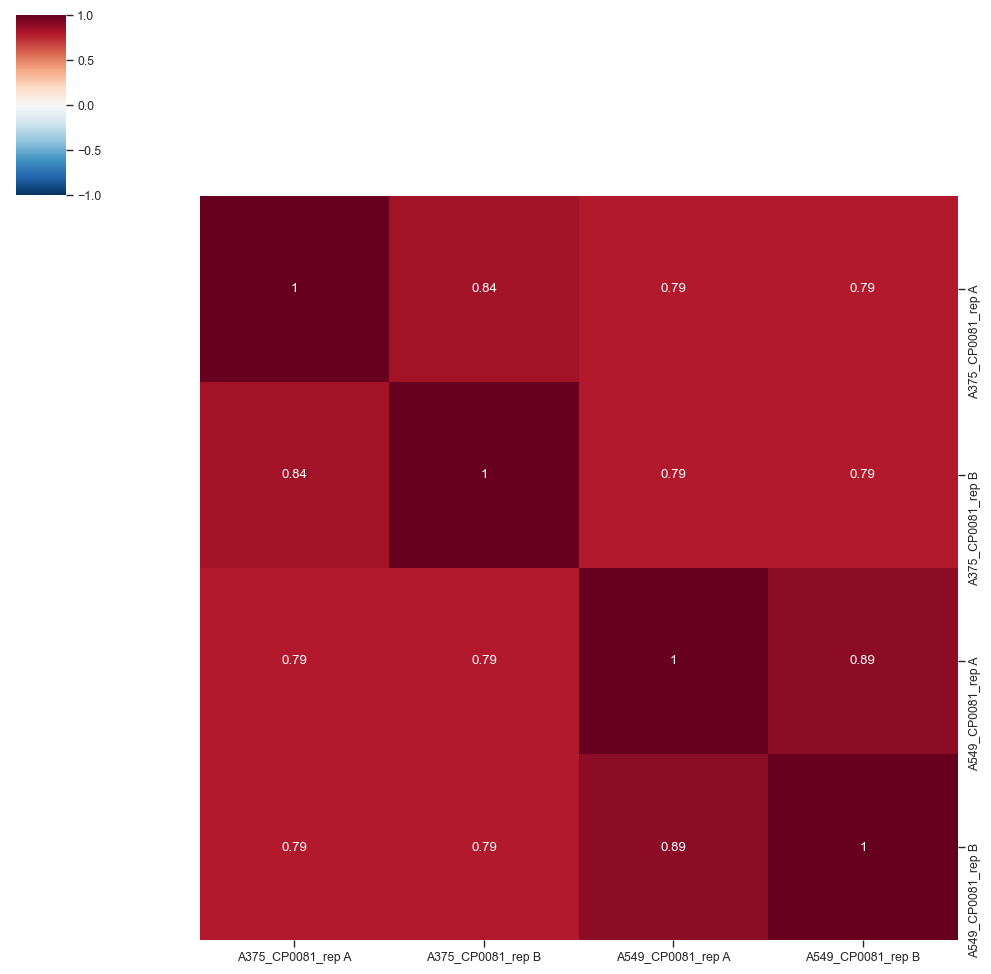

In [11]:
#check replicate correlation
lfc_correlations = lfc_df.corr(numeric_only=True)
sns.clustermap(lfc_correlations, cmap='RdBu_r',
               vmin=-1, vmax=1, annot=True,row_cluster=False,col_cluster=False)

In [17]:
long_lfcs = (lfc_df.melt(id_vars='Construct Barcode',
                         var_name='sample', value_name='lfc'))
long_lfcs[['cell_line','clone_pool','rep']] = long_lfcs['sample'].str.split('_',expand=True)

#average replicates since they demonstrate high correlation
avg_lfcs = (long_lfcs.groupby(['cell_line','Construct Barcode'])
            .agg(avg_lfc = ('lfc', 'mean'),
                 n_obs = ('lfc', 'count'))
            .reset_index())

#subset to cell line of interest
avg_lfcs_a375 = avg_lfcs[avg_lfcs['cell_line'] == 'A375'].copy()

#merge with annotations
annotated_sgrna_lfcs = (avg_lfcs_a375.merge(annotations_df,how='inner',left_on='Construct Barcode',right_on='Barcode Sequence'))
annotated_sgrna_lfcs

,cell_line,Construct Barcode,avg_lfc,n_obs,Barcode Sequence,Gene Symbol,Gene ID
0,A375,AAAAAAGAAAGGATACGTCC,0.015605,2,AAAAAAGAAAGGATACGTCC,FHIT,ENSG00000189283
1,A375,AAAAACAGCTGATGAAACCT,-0.417453,2,AAAAACAGCTGATGAAACCT,CD58,ENSG00000116815
2,A375,AAAAACAGCTGATGAAACCT,-0.417453,2,AAAAACAGCTGATGAAACCT,ENSG00000298543,ENSG00000298543
3,A375,AAAAACCTGGGAAAGATATA,0.351430,2,AAAAACCTGGGAAAGATATA,ZNF669,ENSG00000188295
4,A375,AAAAAGAGGCGGCATTACAG,-0.439691,2,AAAAAGAGGCGGCATTACAG,ENSG00000273957,ENSG00000273957
...,...,...,...,...,...,...,...
68065,A375,TTTGTGGAGCCGGTACATGA,0.913474,2,TTTGTGGAGCCGGTACATGA,CHPF2,ENSG00000033100
68066,A375,TTTGTGGGTACATCTAACCC,0.131153,2,TTTGTGGGTACATCTAACCC,ONE_INTERGENIC_SITE_1026,ONE_INTERGENIC_SITE_1026
68067,A375,TTTGTGGTAGGAGTAGGTGT,-2.460467,2,TTTGTGGTAGGAGTAGGTGT,JMJD8,ENSG00000161999
68068,A375,TTTGTGTATTACCTCAGGAA,0.666838,2,TTTGTGTATTACCTCAGGAA,SPANXN3,ENSG00000189252


In [18]:
control_sgrna_lfcs = (annotated_sgrna_lfcs[(annotated_sgrna_lfcs['Gene Symbol']
                                            .str.contains('ONE_INTERGENIC'))]
                      .reset_index(drop=True))
control_sgrna_lfcs

,cell_line,Construct Barcode,avg_lfc,n_obs,Barcode Sequence,Gene Symbol,Gene ID
0,A375,AAAATAAGTTGAGTCTACCA,0.191173,2,AAAATAAGTTGAGTCTACCA,ONE_INTERGENIC_SITE_1,ONE_INTERGENIC_SITE_1
1,A375,AAAATGACAGAGTAGTATAT,-0.521743,2,AAAATGACAGAGTAGTATAT,ONE_INTERGENIC_SITE_2,ONE_INTERGENIC_SITE_2
2,A375,AAAATGATGTCAGGAAGAAT,0.358006,2,AAAATGATGTCAGGAAGAAT,ONE_INTERGENIC_SITE_3,ONE_INTERGENIC_SITE_3
3,A375,AAAATTAAAGGGCAATAGAG,0.421679,2,AAAATTAAAGGGCAATAGAG,ONE_INTERGENIC_SITE_4,ONE_INTERGENIC_SITE_4
4,A375,AAACCATAGAGATTAAGCTT,-0.152839,2,AAACCATAGAGATTAAGCTT,ONE_INTERGENIC_SITE_5,ONE_INTERGENIC_SITE_5
...,...,...,...,...,...,...,...
1019,A375,TTGGTCACAGTGCTACGCTA,0.445949,2,TTGGTCACAGTGCTACGCTA,ONE_INTERGENIC_SITE_1022,ONE_INTERGENIC_SITE_1022
1020,A375,TTGTGTGGTCTGGTATACTA,0.478209,2,TTGTGTGGTCTGGTATACTA,ONE_INTERGENIC_SITE_1023,ONE_INTERGENIC_SITE_1023
1021,A375,TTGTTACTAAGGAACCCCAA,0.122536,2,TTGTTACTAAGGAACCCCAA,ONE_INTERGENIC_SITE_1024,ONE_INTERGENIC_SITE_1024
1022,A375,TTTATCTGCCTGTAGTGAGT,0.324591,2,TTTATCTGCCTGTAGTGAGT,ONE_INTERGENIC_SITE_1025,ONE_INTERGENIC_SITE_1025


<Axes: >

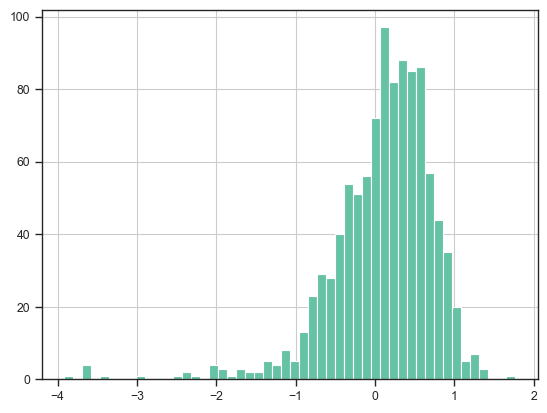

In [19]:
control_sgrna_lfcs['avg_lfc'].hist(bins=50)

In [20]:
neg_ctl_mean = np.mean(control_sgrna_lfcs['avg_lfc'])
neg_ctl_sd = np.std(control_sgrna_lfcs['avg_lfc'])
zscored_sgrna_lfcs = annotated_sgrna_lfcs.copy()
zscored_sgrna_lfcs['z_scored_avg_lfc'] = ((zscored_sgrna_lfcs['avg_lfc'] - neg_ctl_mean)/neg_ctl_sd)
zscored_sgrna_lfcs

,cell_line,Construct Barcode,avg_lfc,n_obs,Barcode Sequence,Gene Symbol,Gene ID,z_scored_avg_lfc
0,A375,AAAAAAGAAAGGATACGTCC,0.015605,2,AAAAAAGAAAGGATACGTCC,FHIT,ENSG00000189283,-0.112495
1,A375,AAAAACAGCTGATGAAACCT,-0.417453,2,AAAAACAGCTGATGAAACCT,CD58,ENSG00000116815,-0.772705
2,A375,AAAAACAGCTGATGAAACCT,-0.417453,2,AAAAACAGCTGATGAAACCT,ENSG00000298543,ENSG00000298543,-0.772705
3,A375,AAAAACCTGGGAAAGATATA,0.351430,2,AAAAACCTGGGAAAGATATA,ZNF669,ENSG00000188295,0.399481
4,A375,AAAAAGAGGCGGCATTACAG,-0.439691,2,AAAAAGAGGCGGCATTACAG,ENSG00000273957,ENSG00000273957,-0.806608
...,...,...,...,...,...,...,...,...
68065,A375,TTTGTGGAGCCGGTACATGA,0.913474,2,TTTGTGGAGCCGGTACATGA,CHPF2,ENSG00000033100,1.256335
68066,A375,TTTGTGGGTACATCTAACCC,0.131153,2,TTTGTGGGTACATCTAACCC,ONE_INTERGENIC_SITE_1026,ONE_INTERGENIC_SITE_1026,0.063662
68067,A375,TTTGTGGTAGGAGTAGGTGT,-2.460467,2,TTTGTGGTAGGAGTAGGTGT,JMJD8,ENSG00000161999,-3.887346
68068,A375,TTTGTGTATTACCTCAGGAA,0.666838,2,TTTGTGTATTACCTCAGGAA,SPANXN3,ENSG00000189252,0.880330


In [21]:
#create pseudogenes
num_pseudogene = 1000
targeting_sgrna_lfcs = (zscored_sgrna_lfcs.loc[(~zscored_sgrna_lfcs['Gene Symbol']
                                            .str.contains('ONE_INTERGENIC')) &
                                              (~zscored_sgrna_lfcs['Gene Symbol']
                                            .str.contains('NO_SITE')) &
                                            (~zscored_sgrna_lfcs['Gene Symbol']
                                            .str.contains('POTENTIALLY_ACTIVE')) &
                                            (~zscored_sgrna_lfcs['Gene Symbol']
                                            .str.contains('INACTIVE')) &
                                            (~zscored_sgrna_lfcs['Gene Symbol']
                                            .str.contains('MULTIPLE_INTERGENIC')),:].copy()
                      .reset_index(drop=True))
#pseudogenes should include same number of guides as real targets
n_guides = targeting_sgrna_lfcs.groupby('Gene Symbol')['Construct Barcode'].nunique().mode()[0]
control_sgrnas = control_sgrna_lfcs['Construct Barcode'].unique()
pseudogene_df_list = []

#randomly sample negative controls to create pseudogenes
random.seed(0)
for i in range(num_pseudogene):
     if i%100 == 0:
         print(i)
     chosen_guides = random.choices(control_sgrnas, k=n_guides)
     temp_df_list = []
     for j in range(n_guides):
         g = chosen_guides[j]
         temp_row = zscored_sgrna_lfcs.loc[(zscored_sgrna_lfcs['Construct Barcode'] == g) &
                                           (zscored_sgrna_lfcs['Gene Symbol'].str.contains('ONE_INTERGENIC')),:].copy()
         temp_row.loc[:,'Construct Barcode'] = g + 'p' + str(i) + 'g' + str(j)
         temp_df_list.append(temp_row)
     temp_df = pd.concat(temp_df_list,ignore_index=True)
     temp_df.loc[:,'Gene Symbol'] = 'Pseudogene_' + str(i)
     pseudogene_df_list.append(temp_df)

pseudogene_df = pd.concat(pseudogene_df_list).reset_index(drop=True)
pseudogene_df

0
100
200
300
400
500
600
700
800
900


,cell_line,Construct Barcode,avg_lfc,n_obs,Barcode Sequence,Gene Symbol,Gene ID,z_scored_avg_lfc
0,A375,TATAACACTCAAGTCAACCCp0g0,0.315840,2,TATAACACTCAAGTCAACCC,Pseudogene_0,ONE_INTERGENIC_SITE_866,0.345223
1,A375,GTGGTAGGAAACCTTATCTCp0g1,0.865621,2,GTGGTAGGAAACCTTATCTC,Pseudogene_0,ONE_INTERGENIC_SITE_778,1.183382
2,A375,ATGTATATGGTCCTAACTATp0g2,-0.067112,2,ATGTATATGGTCCTAACTAT,Pseudogene_0,ONE_INTERGENIC_SITE_431,-0.238600
3,A375,AGCACATCTACGAGTCTACAp1g0,0.929269,2,AGCACATCTACGAGTCTACA,Pseudogene_1,ONE_INTERGENIC_SITE_266,1.280415
4,A375,GAACAAAGGCCGGCAAACCAp1g1,-0.239600,2,GAACAAAGGCCGGCAAACCA,Pseudogene_1,ONE_INTERGENIC_SITE_524,-0.501562
...,...,...,...,...,...,...,...,...
2995,A375,GCACACACGATATTAGACCCp998g1,-1.086788,2,GCACACACGATATTAGACCC,Pseudogene_998,ONE_INTERGENIC_SITE_602,-1.793129
2996,A375,AAATGAGATCAGGTACACTAp998g2,0.145582,2,AAATGAGATCAGGTACACTA,Pseudogene_998,ONE_INTERGENIC_SITE_26,0.085660
2997,A375,ATACAGGCTTCCGTGACCTCp999g0,0.060097,2,ATACAGGCTTCCGTGACCTC,Pseudogene_999,ONE_INTERGENIC_SITE_365,-0.044666
2998,A375,AGGTGGTGTACACTTTCGCAp999g1,0.514542,2,AGGTGGTGTACACTTTCGCA,Pseudogene_999,ONE_INTERGENIC_SITE_316,0.648151


In [22]:
#redefine zscored_sgrna_lfcs to include both targeting and pseudogene z-scores + annotations
zscored_sgrna_lfcs = pd.concat([targeting_sgrna_lfcs,pseudogene_df]).reset_index(drop=True)
#save sgrna level values
zscored_sgrna_lfcs.to_csv('../../Data/externalData/jacquere_a375_zscored_sgrna_lfcs.csv', index = False)

In [23]:
zscored_sgrna_lfcs = pd.read_csv('../../Data/externalData/jacquere_a375_zscored_sgrna_lfcs.csv')

In [25]:
#calculate gene-level z-scores using Stouffer's method
zscored_gene_lfcs = (zscored_sgrna_lfcs.groupby(['cell_line','Gene Symbol'])
                     .agg(z_scored_lfc_sum = ('z_scored_avg_lfc', 'sum'),
                          n_sgrnas = ('avg_lfc', 'count'))
                     .reset_index())
zscored_gene_lfcs['z_scored_avg_lfc'] = (zscored_gene_lfcs['z_scored_lfc_sum']/np.sqrt(zscored_gene_lfcs['n_sgrnas']))
zscored_gene_lfcs = zscored_gene_lfcs.drop('z_scored_lfc_sum', axis=1)

zscored_gene_lfcs

,cell_line,Gene Symbol,n_sgrnas,z_scored_avg_lfc
0,A375,A1BG,3,-2.748797
1,A375,A1BG-AS1,1,0.486127
2,A375,A1CF,3,1.944724
3,A375,A2M,3,0.354338
4,A375,A2ML1,3,1.185321
...,...,...,...,...
23236,A375,ZYG11A,3,0.033326
23237,A375,ZYG11B,3,-2.429798
23238,A375,ZYX,3,0.075297
23239,A375,ZZEF1,3,1.210517


In [26]:
#define function to calculate one-sided (negative selection) empirical p-value by calculating area under curve of null distribution of pseudogene z-scores
control_pseudogene_zscores = zscored_gene_lfcs[zscored_gene_lfcs['Gene Symbol'].str.contains('Pseudo')]['z_scored_avg_lfc'].tolist()

def get_empirical_gene_pval(gene_level_z_score):
    kde= scipy.stats.gaussian_kde(control_pseudogene_zscores)
    ha_less=kde.integrate_box_1d(-np.inf, gene_level_z_score)
    return ha_less

In [27]:
zscored_gene_lfcs['p_value'] = zscored_gene_lfcs['z_scored_avg_lfc'].apply(get_empirical_gene_pval)
zscored_gene_lfcs['FDR'] = multipletests(zscored_gene_lfcs['p_value'],method='fdr_bh')[1]
zscored_gene_lfcs

,cell_line,Gene Symbol,n_sgrnas,z_scored_avg_lfc,p_value,FDR
0,A375,A1BG,3,-2.748797,0.024910,0.127271
1,A375,A1BG-AS1,1,0.486127,0.682837,0.878997
2,A375,A1CF,3,1.944724,0.989910,0.999153
3,A375,A2M,3,0.354338,0.625811,0.846692
4,A375,A2ML1,3,1.185321,0.909015,0.977140
...,...,...,...,...,...,...
23236,A375,ZYG11A,3,0.033326,0.487335,0.755007
23237,A375,ZYG11B,3,-2.429798,0.034304,0.157036
23238,A375,ZYX,3,0.075297,0.504922,0.767940
23239,A375,ZZEF1,3,1.210517,0.914110,0.978235


In [29]:
zscored_gene_lfcs.to_csv('../../Data/externalData/jacquere_a375_zscored_gene_lfcs.csv', index = False)